In [24]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2023
### Student Name: Koleh David, Seth Ossowicz
### Student ID: a1742571, a1771732
### Comptetion Name: Flowers Classification Competition
### Final Results:
### ACC: 98.9%        FLOPs: 0.04G
##################################################################################################################################

In [2]:
# Importing libraries.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

In [3]:
# Performing Image Transformations.

train_transform=transforms.Compose([
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [4]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Network Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')

# Dataset path.
data_directory = '/content/drive/MyDrive/Colab Notebooks/a4/Datasets/flower/flowers'
dataset=datasets.ImageFolder(root=data_directory,transform=train_transform)
dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset ImageFolder
    Number of datapoints: 4317
    Root location: /content/drive/MyDrive/Colab Notebooks/a4/Datasets/flower/flowers
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
# Checking the flower class types.
class_names=dataset.classes
print(class_names)
print(len(class_names))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
5


In [6]:
# Train and Test data split.
train_indices, test_indices = train_test_split(list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets)
train_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, test_indices)

In [7]:
train_loader=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader=DataLoader(test_data,batch_size=10)

In [8]:
print(len(train_data))
print(len(test_data))

3453
864


In [9]:
# Preview of the datasets.
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=5)

Label: [0 1 4 2 2 4 2 0 1 3]
Class: daisy dandelion tulip rose rose tulip rose daisy dandelion sunflower


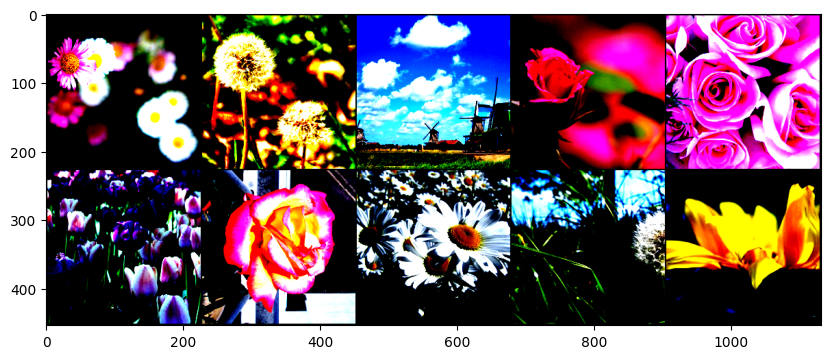

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [11]:
# Inverse Normalization.
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                     std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

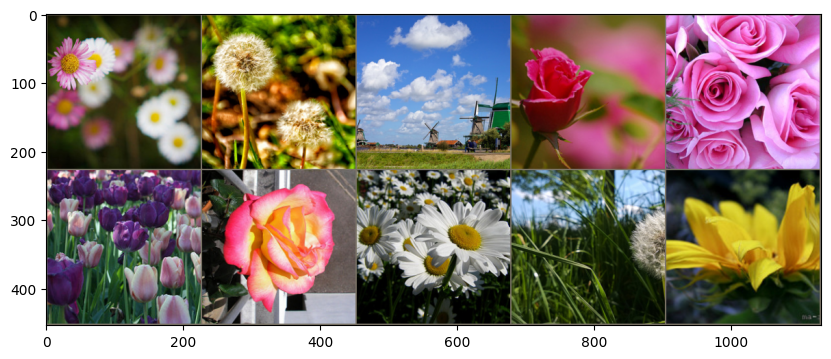

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [13]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,6,3,1)
        self.conv1_bn=nn.BatchNorm2d(6)

        self.conv2=nn.Conv2d(6,16,3,1)
        self.conv2_bn=nn.BatchNorm2d(16)

        self.fc1=nn.Linear(16*54*54,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,20)
        self.fc4=nn.Linear(20,self.num_classes)

    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,16*54*54)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=F.relu(self.fc3(X))
        X=self.fc4(X)

        return F.log_softmax(X, dim=1)

In [14]:
num_classes = 5
CNNmodel=ConvolutionalNetwork(num_classes)
criterion=nn.CrossEntropyLoss()
LOSS_RATE=0.001
optimizer=torch.optim.Adam(CNNmodel.parameters(),lr=LOSS_RATE)

In [15]:
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=5, bias=True)
)

In [16]:
# Counting of number of parameters in the model.
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(CNNmodel)

     162
       6
       6
       6
     864
      16
      16
      16
 5598720
     120
   10080
      84
    1680
      20
     100
       5
________
 5611901


In [17]:
# Learning Schema.
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
epochs=10

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1
        y_pred=CNNmodel(X_train)
        loss=criterion(y_pred,y_train)

        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200==0:
            print(f"epoch: {i+1} loss: {loss.item()} batch: {b} accuracy: {trn_corr.item()*100/(10*b):7.3f}%")
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)


    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val=CNNmodel(X_test)
            loss=criterion(y_val,y_test)

            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr

        loss=loss.detach().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch: 1 loss: 1.4681870937347412 batch: 200 accuracy:  41.950%
epoch: 2 loss: 0.5326734781265259 batch: 200 accuracy:  58.650%
epoch: 3 loss: 0.8632768392562866 batch: 200 accuracy:  67.100%
epoch: 4 loss: 0.769649088382721 batch: 200 accuracy:  77.050%
epoch: 5 loss: 0.20788820087909698 batch: 200 accuracy:  88.400%
epoch: 6 loss: 0.19992104172706604 batch: 200 accuracy:  92.500%
epoch: 7 loss: 0.1857873499393463 batch: 200 accuracy:  94.750%
epoch: 8 loss: 0.001938721863552928 batch: 200 accuracy:  98.450%
epoch: 9 loss: 0.029565516859292984 batch: 200 accuracy:  98.100%
epoch: 10 loss: 0.010931207798421383 batch: 200 accuracy:  98.900%

Duration: 655 seconds


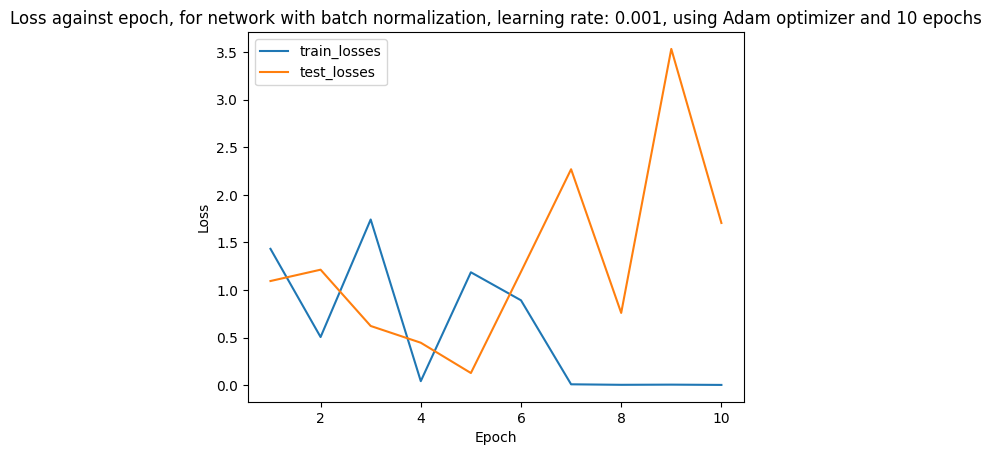

In [25]:
# Plotting loss over time.
plt.plot(range(1,epochs+1),train_losses,label="train_losses")
plt.plot(range(1,epochs+1),test_losses,label="test_losses")
plt.title(f"Loss against epoch, for network with batch normalization, learning rate: {LOSS_RATE}, using Adam optimizer and 10 epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

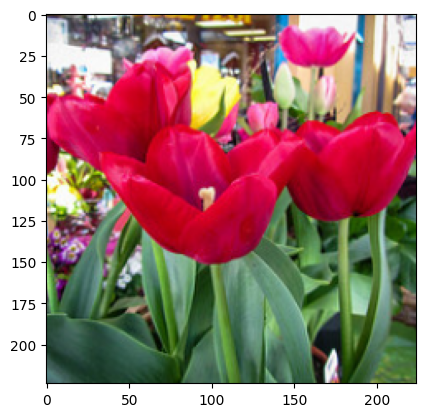

In [19]:
x=100
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [20]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [21]:
# Prediction for one of the samples.
CNNmodel.eval()
with torch.no_grad():
    new_pred=CNNmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 4 tulip


##FLOPs

In [22]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
  !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  !mv download FLOPs_counter.py
  #!rm -rf download

--2023-06-22 13:19:41--  https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
Resolving cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)... 202.158.207.20
Connecting to cloudstor.aarnet.edu.au (cloudstor.aarnet.edu.au)|202.158.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: 5230042dc1897=qogcr38fj71rv9h7q4nq7moe88; path=/plus; domain=.aarnet.edu.au;; Secure; SameSite=Lax at position 76.
Syntax error in Set-Cookie: oc_sessionPassphrase=lKLufQaC%2FeIysa0XWFCQxhk4%2FNoaENl6cU%2B%2Bw00r2uge7wFVKS4ZOQnFuPw3QYC2qQJ7gL%2FpeHpm4Hl2HUohAiPjzCN4gaQZ5KyMPnOOGZCBh8PVnvUQlvG1QyiU%2BXwI; expires=Fri, 23-Jun-2023 13:19:42 GMT; Max-Age=86400; path=/plus;; Secure; SameSite=Lax at position 228.
Length: 5201 (5.1K) [text/x-python]
Saving to: ‘download’

download            100%[===================>]   5.08K  --.-KB/s    in 0s      

2023-06-22 13:19:42 (889 MB/s) - ‘download’ saved [5201/5201]



In [23]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 224, 224) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 5
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.04G
